# Factor Analysis including SVI's

## Imports

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import json
import requests
import pickle
import pandas as pd
import numpy as np
import copy
import warnings
import scipy.stats as stats
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import resample

In [ ]:
#!pip install pingouin
#import pingouin as pg

In [ ]:
US_health_zip_df = pd.read_pickle("..\\..\\data\\US_ZIP_health_df.pkl")
CA_zip_misc_svi_df = pd.read_pickle('CA_zip_vaccination_svi_cleaned_df.pkl')
CA_zip_misc_svi_all_df = pd.read_pickle('CA_zip_vaccination_svi_df.pkl')

In [ ]:
list(CA_zip_misc_svi_all_df.columns)

['GEOID10',
 'latitude',
 'longitude',
 'zipcode',
 'geometry',
 'state',
 'county',
 'population',
 'population_density',
 'median_home_value',
 'median_household_income',
 'M_Under_5',
 'M_5-9',
 'M_10-14',
 'M_15-19',
 'M_20-24',
 'M_25-29',
 'M_30-34',
 'M_35-39',
 'M_40-44',
 'M_45-49',
 'M_50-54',
 'M_55-59',
 'M_60-64',
 'M_65-69',
 'M_70-74',
 'M_75-79',
 'M_80-84',
 'M_85_Plus',
 'F_Under_5',
 'F_5-9',
 'F_10-14',
 'F_15-19',
 'F_20-24',
 'F_25-29',
 'F_30-34',
 'F_35-39',
 'F_40-44',
 'F_45-49',
 'F_50-54',
 'F_55-59',
 'F_60-64',
 'F_65-69',
 'F_70-74',
 'F_75-79',
 'F_80-84',
 'F_85_Plus',
 'School_Public',
 'School_Private',
 'School_None',
 'Educ_<HS',
 'Educ_HS',
 'Educ_AA',
 'Educ_BA',
 'Educ_Msters',
 'Educ_Prof',
 'Educ_Doctorate',
 '<10Min_to_work',
 '<20Min_to_work',
 '<30Min_to_work',
 '<40Min_to_work',
 '<50Min_to_work',
 '<60Min_to_work',
 '<90Min_to_work',
 '>90Min_to_work',
 'Whites_count',
 'AA_count',
 'AI_Alaskan_count',
 'Asian_count',
 'Hawaiian_PI_count',

## Z and Temp2

In [ ]:
temp1_df = pd.concat([CA_zip_misc_svi_df,CA_zip_misc_svi_all_df[['SVI1','SVI2','SVI3','SVI4','SVI']]], axis=1, join='inner')
z = pd.concat([temp1_df,US_health_zip_df], axis=1, join='inner')

In [ ]:
z.shape

(1555, 159)

In [ ]:
temp2 = pd.DataFrame()

In [ ]:
temp2['young_children_prop'] = z['M_5-9_prop'] + z['M_Under_5_prop'] + z['F_5-9_prop'] + z['F_Under_5_prop']

temp2['school_children_prop'] = z['M_10-14_prop'] + z['M_15-19_prop'] + z['F_10-14_prop'] + z['F_15-19_prop']

temp2['M_20_44'] = z['M_20-24_prop' ] + z[ 'M_25-29_prop' ] + z[ 'M_30-34_prop' ] + z[ 'M_35-39_prop'] + z['M_40-44_prop']
temp2['M_45_69'] = z['M_45-49_prop' ] + z[ 'M_50-54_prop' ] + z[ 'M_55-59_prop' ] + z[ 'M_60-64_prop' ] + z[ 'M_65-69_prop']
temp2['M_70_Plus'] = z['M_70-74_prop' ] + z[ 'M_75-79_prop' ] + z[ 'M_80-84_prop' ] + z[ 'M_85_Plus_prop']

temp2['F_20_44'] = z['F_20-24_prop' ] + z[ 'F_25-29_prop' ] + z[ 'F_30-34_prop' ] + z[ 'F_35-39_prop'] + z['F_40-44_prop']
temp2['F_45_69'] = z['F_45-49_prop' ] + z[ 'F_50-54_prop' ] + z[ 'F_55-59_prop' ] + z[ 'F_60-64_prop' ] + z[ 'F_65-69_prop']
temp2['F_70_Plus'] = z['F_70-74_prop' ] + z[ 'F_75-79_prop' ] + z[ 'F_80-84_prop' ] + z[ 'F_85_Plus_prop']

temp2['Educ_AA_or_Less'] = z['School_None_prop' ] + z[ 'Educ_<HS_prop' ] + z[ 'Educ_AA_prop']
temp2['Educ_BA_or_Higher'] = z['Educ_BA_prop' ] + z[ 'Educ_Msters_prop' ] + z[ 'Educ_Prof_prop' ] + z[ 'Educ_Doctorate_prop']

temp2['Commute_10_or_Less'] = z['<10Min_to_work_prop' ] + z[  'walk_commute_prop' ] + z[ 'work_at_home_prop']
temp2['Commute_10_50Min'] = z['<20Min_to_work_prop' ] + z[  '<30Min_to_work_prop'] + z[ '<40Min_to_work_prop' ] + z[ '<50Min_to_work_prop']
temp2['Commute_50_Plus'] = z['<60Min_to_work_prop' ] + z[ '<90Min_to_work_prop' ] + z[ '<90Min_to_work_prop']

temp2['HHI_Poverty'] = z['<25K_HHI_prop' ] + z[ '<45K_HHI_prop']
temp2['HHI_Low'] = z['<60K_HHI_prop' ] + z[ '<100K_HHI_prop']
temp2['HHI_Moderate'] = z['<150K_HHI_prop' ] + z[ '<200K_HHI_prop']
temp2['HHI_High'] = z['>200K_HHI_prop']

temp2['Home_Value_Low'] = z['<25K_Home_Value_prop' ] + z[ '<50K_Home_Value_prop' ] + z[ '<100k_Home_Value_prop']
temp2['Home_Value_Medium'] = z['<150K_Home_Value_prop' ] + z[ '<200K_Home_Value_prop' ] + z[ '<400K_Home_Value_prop']
temp2['Home_Value_High'] = z['<750K_Home_Value_prop' ] + z[ '>750K_Home_Value_prop']

temp2['2Bdrm_or_Less'] = z['Studio_Count_prop'] + z[ '1Bdrm_Count_prop' ] + z[ '2Bdrm_Count_prop']

temp2['Vacancy_Rent_Sale'] = z['Vacant_For_Rent_prop' ] + z[ 'Rented_Unoccupied_prop' ] + z[ 'Vacant_For_Sale_prop' ] + z[ 'Vacant_Sold_Unoccupied_prop']
temp2['Vacancy_Recreation_Other'] = z['Vacant_Recreational_Occasional_prop' ] + z[ 'Vacant_For_Migrant_Workers_prop' ] + z[ 'Vacant_Other_Reasons_prop']

temp2['Home_Age_Pre1930'] = z['<1930_built_prop']
temp2['Home_Age_1930_1970'] = z['1940_built_prop' ] + z[ '1950_built_prop' ] + z[ '1960_built_prop']
temp2['Home_Age_1970_2000'] = z['1970_built_prop' ] + z[ '1980_built_prop' ] + z[ '1990_built_prop']

temp2['Home_Not_Owned'] = z['Home_Owned_Mortgaged_prop'] + z[ 'Home_Rented_prop']
temp2['Home_Owned'] = z['Home_Owned_prop' ] + z[ 'Home_Vacant_prop']

temp2['Living_Not_Home'] = z['Correctional_prop' ] + z[ 'Juvenile_prop' ] + z[ 'Institutional_prop' ] + z[ 'College_prop' ] + z[ 'Military_prop'] 
temp2['Living_Home'] = z['In Occupied Housing Units_prop' ] + z[ 'Noninstitutional_prop']

temp2['Not_Single_Parent_Family'] = z['Husband_Wife_Family_prop' ] + z['Single_Family_prop' ] + z[ 'Single_w_roommate_Family_prop']

temp2['indicators_bad_health']= z['Current lack of health insurance among adults aged 18-64 years'] + z['Physical health not good for >=14 days among adults aged >=18 years'] + z['Sleeping less than 7 hours among adults aged >=18 years'] + z['Obesity among adults aged >=18 years'] + z['No leisure-time physical activity among adults aged >=18 years'] + z['Mental health not good for >=14 days among adults aged >=18 years'] + z['Current smoking among adults aged >=18 years']
temp2['indicators_good_health'] = z['Visits to doctor for routine checkup within the past year among adults aged >=18 years'] + z['Visits to dentist or dental clinic among adults aged >=18 years'] + z['Older adult women aged >=65 years who are up to date on a core set of clinical preventive services: Flu shot past year, PPV shot ever, Colorectal cancer screening, and Mammogram past 2 years'] + z['Older adult men aged >=65 years who are up to date on a core set of clinical preventive services: Flu shot past year, PPV shot ever, Colorectal cancer screening'] + z['Mammography use among women aged 50-74 years'] + z['Cervical cancer screening among adult women aged 21-65 years'] + z['Cholesterol screening among adults aged >=18 years'] + z['Fecal occult blood test, sigmoidoscopy, or colonoscopy among adults aged 50-75 years']
temp2['normal_diseases'] = z['Arthritis among adults aged >=18 years'] + z['Current asthma among adults aged >=18 years'] + z['Diagnosed diabetes among adults aged >=18 years'] + z['High blood pressure among adults aged >=18 years'] + z['High cholesterol among adults aged >=18 years who have been screened in the past 5 years'] + z['Taking medicine for high blood pressure control among adults aged >=18 years with high blood pressure']
temp2['dangerous_diseases'] = z['All teeth lost among adults aged >=65 years'] + z['Binge drinking among adults aged >=18 years'] + z['Cancer (excluding skin cancer) among adults aged >=18 years'] + z['Chronic kidney disease among adults aged >=18 years'] + z['Chronic obstructive pulmonary disease among adults aged >=18 years'] + z['Coronary heart disease among adults aged >=18 years'] + z['Stroke among adults aged >=18 years']

In [ ]:
temp2.shape

(1555, 35)

## Bartlett's Sphericity and KMO

In [ ]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(temp2)
kmo_model

C:\Users\gavir\.conda\envs\geo_r\lib\site-packages\factor_analyzer\utils.py:249: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


0.7970367848895323

## EFA

In [ ]:
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer(rotation=None)
fa.fit(temp2)
ev, v = fa.get_eigenvalues()
ev

array([ 9.91996154e+00,  8.27463045e+00,  2.96585420e+00,  2.35740479e+00,
        1.76421115e+00,  1.54794874e+00,  1.38329329e+00,  1.09613749e+00,
        8.73554699e-01,  7.71794863e-01,  6.61195270e-01,  4.93185562e-01,
        4.64723694e-01,  4.22381523e-01,  3.20052473e-01,  2.98018091e-01,
        2.39950560e-01,  2.26495665e-01,  2.08077790e-01,  1.58785419e-01,
        1.13340697e-01,  1.08474626e-01,  8.24159362e-02,  6.65072586e-02,
        5.94477661e-02,  4.99662572e-02,  2.84926461e-02,  1.86537072e-02,
        1.40547306e-02,  1.09891027e-02,  2.51263101e-16,  1.10753857e-16,
        5.44582198e-17,  2.92558190e-17, -2.02643141e-16])

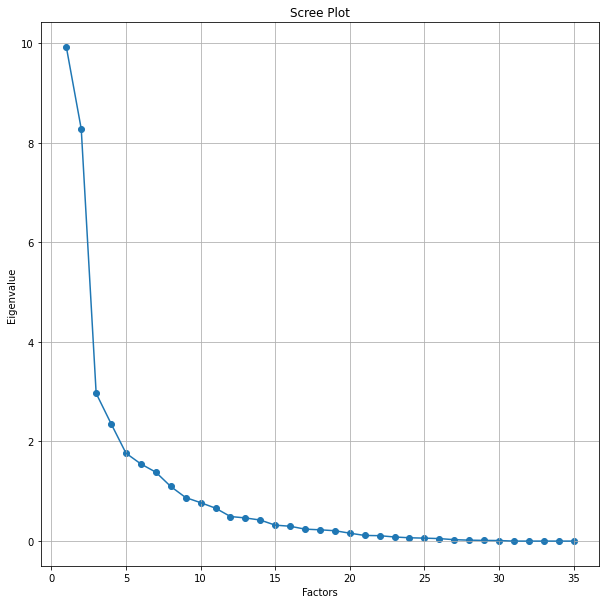

In [ ]:
plt.subplots(figsize=(10,10))
plt.scatter(range(1,temp2.shape[1]+1),ev)
plt.plot(range(1,temp2.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [ ]:
from factor_analyzer import FactorAnalyzer, Rotator
fa = FactorAnalyzer(rotation="varimax", n_factors=4)
fa.fit(temp2)
rotator = Rotator()
loadings_df = pd.DataFrame(rotator.fit_transform(fa.loadings_))

In [ ]:
loadings_df.index = temp2.columns
loadings_df.columns = ['F1', 'F2', 'F3', 'F4']
loadings_df.sort_values(by = ['F1', 'F2', 'F3', 'F4'])
loadings_df.style.highlight_max(color = 'lightgreen', axis = 1)


,F1,F2,F3,F4
young_children_prop,-0.585495,-0.502658,-0.261214,0.174719
school_children_prop,-0.449884,-0.402499,-0.447103,-0.039947
M_20_44,-0.733940,-0.035704,0.357435,-0.379176
M_45_69,0.835730,0.327632,-0.081239,0.129154
M_70_Plus,0.734524,0.183966,0.130944,0.177022
F_20_44,-0.784686,0.015703,0.313727,-0.231246
F_45_69,0.832802,0.318856,-0.115928,0.138613
F_70_Plus,0.602747,0.196413,0.222980,0.156867
Educ_AA_or_Less,-0.299252,-0.773464,0.017483,0.031379
Educ_BA_or_Higher,0.005222,0.904676,0.196850,-0.066882


In [ ]:
loadings_df[['F1', 'F2', 'F3', 'F4']] = loadings_df[['F1', 'F2', 'F3', 'F4']].abs()
loadings_df.abs()
loadings_df.style.highlight_max(color = 'lightgreen', axis = 1)

,F1,F2,F3,F4
young_children_prop,0.585495,0.502658,0.261214,0.174719
school_children_prop,0.449884,0.402499,0.447103,0.039947
M_20_44,0.733940,0.035704,0.357435,0.379176
M_45_69,0.835730,0.327632,0.081239,0.129154
M_70_Plus,0.734524,0.183966,0.130944,0.177022
F_20_44,0.784686,0.015703,0.313727,0.231246
F_45_69,0.832802,0.318856,0.115928,0.138613
F_70_Plus,0.602747,0.196413,0.222980,0.156867
Educ_AA_or_Less,0.299252,0.773464,0.017483,0.031379
Educ_BA_or_Higher,0.005222,0.904676,0.196850,0.066882


In [ ]:
from factor_analyzer import (ConfirmatoryFactorAnalyzer, ModelSpecificationParser)
model_dict = {"F1": ['Home_Owned','indicators_bad_health','normal_diseases','M_45_69','F_45_69','M_70_Plus','F_70_Plus','Commute_10_or_Less','Vacancy_Recreation_Other'],
              
              "F2": ['Educ_BA_or_Higher','HHI_Moderate','HHI_High','Home_Value_High','indicators_good_health','Not_Single_Parent_Family'],
              
              "F3": ['young_children_prop','school_children_prop','M_20_44','F_20_44','HHI_Poverty','2Bdrm_or_Less','Home_Age_Pre1930','Home_Age_1930_1970'],
              
              "F4": ['Living_Not_Home']
              
             }

In [ ]:
temp3 = temp2.drop(['young_children_prop','school_children_prop','Educ_AA_or_Less','Commute_10_50Min','HHI_Low','Home_Value_Low','Home_Value_Medium','Home_Not_Owned','Home_Age_1970_2000','Vacancy_Rent_Sale','Living_Not_Home','dangerous_diseases'], axis = 1)

In [ ]:
temp3['vaccinated'] = z['population'] - z['Not_Vaccinated_Count']
temp3.head()

,M_20_44,M_45_69,M_70_Plus,F_20_44,F_45_69,F_70_Plus,Educ_BA_or_Higher,Commute_10_or_Less,Commute_50_Plus,HHI_Poverty,HHI_Moderate,HHI_High,Home_Value_High,2Bdrm_or_Less,Vacancy_Recreation_Other,Home_Age_Pre1930,Home_Age_1930_1970,Home_Owned,Living_Home,Not_Single_Parent_Family,indicators_bad_health,indicators_good_health,normal_diseases,vaccinated
90001,0.388823,0.190178,0.028980,0.377104,0.195343,0.044725,0.036223,0.110481,0.297886,0.623484,0.066898,0.003862,0.154455,0.806548,0.293758,0.307653,0.433961,0.122933,0.999895,0.620847,198.3,427.2,160.2,36805.281930
90002,0.366015,0.188455,0.029788,0.362242,0.202528,0.046874,0.039293,0.103358,0.286308,0.644901,0.065638,0.007541,0.064038,0.684436,0.253749,0.309851,0.440964,0.129306,1.000000,0.569005,199.6,433.3,167.5,22602.251196
90003,0.381907,0.187490,0.026355,0.377167,0.201546,0.041207,0.059212,0.109326,0.283023,0.682219,0.049034,0.002439,0.096578,0.749412,0.287542,0.338010,0.419320,0.133707,0.999909,0.587521,201.7,429.9,165.9,28954.266040
90004,0.455754,0.256437,0.044023,0.405726,0.290433,0.068107,0.330894,0.138378,0.308789,0.573553,0.108001,0.054460,0.861722,0.933983,0.224148,0.378167,0.326064,0.110635,0.999727,0.766266,146.1,479.5,154.1,38677.638860
90005,0.482616,0.232499,0.049433,0.420520,0.267490,0.088837,0.262820,0.164606,0.402604,0.677337,0.060047,0.016365,0.691369,0.964344,0.146810,0.373444,0.301402,0.092567,0.999363,0.776256,155.6,461.5,158.1,21075.284748


## CFA

In [ ]:
model_spec = ModelSpecificationParser.parse_model_specification_from_dict(temp3, model_dict)

cfa = ConfirmatoryFactorAnalyzer(model_spec, disp=False) 

cfa.fit(temp3.values) 

cfa.loadings_

array([[ 5.13154292e+02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 5.19171158e+02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 5.17843603e+02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 5.13109336e+02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 5.18846176e+02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 5.16960712e+02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 5.07771742e+02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 5.20494269e+02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 5.14309874e+02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  3.67066262e+02,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  3.66101744e+02,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  3.66156311e+02,  0.00000000e+00,
      

In [ ]:
cfa.get_standard_errors()

(array([[9.14721455e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [9.25485339e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [9.23116885e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [9.14638234e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [9.24900930e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [9.21528247e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [9.05026753e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [9.27868257e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [9.16775747e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 6.54206950e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 6.52481987e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 6.52569793e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 6.44612506e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 6.49634669e+0

## Predictive Analysis

In [ ]:
#temp3 is our data set with all the variables chosen for factors

In [ ]:
#conda install -c conda-forge tableone

In [ ]:
import sklearn
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr, pearsonr
from sklearn import preprocessing
#from sklearn.preprocessing import Imputer
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
import copy
import warnings
import scipy.stats as stats
from scipy.stats import ttest_ind, mannwhitneyu, wilcoxon
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from scipy.stats import ttest_ind, mannwhitneyu, wilcoxon
from tableone import TableOne

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
#!pip install plotly

In [ ]:
#With variables that have correlation at least .1 with unvaccinated count
#Create a decent table (https://plotly.com/python/table/)
import plotly.graph_objects as go
cols = ["Model".format(fontsize=18), "Error Metric".format(fontsize=18), "Variance Explained(+/- 2SD)".format(fontsize=18)]
results_df = pd.DataFrame(columns=cols)
model_names=[]
model_metric = []
model_error = []

In [ ]:
model_factory = [
    LinearRegression(),
    Lasso(),
    Ridge(),
    ElasticNet(),
    DecisionTreeRegressor(),
    SVR(),
    KNeighborsRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor()]

In [ ]:
temp3['vaccinated'] = z['population'] - z['Not_Vaccinated_Count']
temp3['Not_Vaccinated_Count'] = z['Not_Vaccinated_Count']

In [ ]:
z['vaccinated'] = z['population'] - z['Not_Vaccinated_Count']

In [ ]:
#With variables that have correlation at least .1 with unvaccinated count
#Create a decent table (https://plotly.com/python/table/)
import plotly.graph_objects as go
cols = ["Model".format(fontsize=18), "Error Metric".format(fontsize=18), "Variance Explained(+/- 2SD)".format(fontsize=18)]
results_df = pd.DataFrame(columns=cols)
model_names=[]
model_metric = []
model_error = []

In [ ]:
model_factory = [
    LinearRegression(),
    Lasso(),
    Ridge(),
    ElasticNet(),
    DecisionTreeRegressor(),
    SVR(),
    KNeighborsRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor()]

In [ ]:
list(z.columns)

['M_Under_5_prop',
 'M_5-9_prop',
 'M_10-14_prop',
 'M_15-19_prop',
 'M_20-24_prop',
 'M_25-29_prop',
 'M_30-34_prop',
 'M_35-39_prop',
 'M_40-44_prop',
 'M_45-49_prop',
 'M_50-54_prop',
 'M_55-59_prop',
 'M_60-64_prop',
 'M_65-69_prop',
 'M_70-74_prop',
 'M_75-79_prop',
 'M_80-84_prop',
 'M_85_Plus_prop',
 'F_Under_5_prop',
 'F_5-9_prop',
 'F_10-14_prop',
 'F_15-19_prop',
 'F_20-24_prop',
 'F_25-29_prop',
 'F_30-34_prop',
 'F_35-39_prop',
 'F_40-44_prop',
 'F_45-49_prop',
 'F_50-54_prop',
 'F_55-59_prop',
 'F_60-64_prop',
 'F_65-69_prop',
 'F_70-74_prop',
 'F_75-79_prop',
 'F_80-84_prop',
 'F_85_Plus_prop',
 'School_Public_prop',
 'School_Private_prop',
 'School_None_prop',
 'Educ_<HS_prop',
 'Educ_HS_prop',
 'Educ_AA_prop',
 'Educ_BA_prop',
 'Educ_Msters_prop',
 'Educ_Prof_prop',
 'Educ_Doctorate_prop',
 '<10Min_to_work_prop',
 '<20Min_to_work_prop',
 '<30Min_to_work_prop',
 '<40Min_to_work_prop',
 '<50Min_to_work_prop',
 '<60Min_to_work_prop',
 '<90Min_to_work_prop',
 '>90Min_to_wor

In [ ]:
list(temp3.columns)

['M_20_44',
 'M_45_69',
 'M_70_Plus',
 'F_20_44',
 'F_45_69',
 'F_70_Plus',
 'Educ_BA_or_Higher',
 'Commute_10_or_Less',
 'Commute_50_Plus',
 'HHI_Poverty',
 'HHI_Moderate',
 'HHI_High',
 'Home_Value_High',
 '2Bdrm_or_Less',
 'Vacancy_Recreation_Other',
 'Home_Age_Pre1930',
 'Home_Age_1930_1970',
 'Home_Owned',
 'Living_Home',
 'Not_Single_Parent_Family',
 'indicators_bad_health',
 'indicators_good_health',
 'normal_diseases',
 'vaccinated',
 'Not_Vaccinated_Count']

In [ ]:
temp3.sort_values('vaccinated')
temp3_y = temp3['Not_Vaccinated_Count']
temp3_X = temp3.drop(['vaccinated','Not_Vaccinated_Count'], axis = 1)

In [ ]:
#Evaluate the models
for model in model_factory:
    model.seed = 123456
    num_folds = 5
    
    scores = cross_val_score(model, temp3_X, temp3_y, cv=num_folds, scoring='explained_variance', n_jobs=-1)

    score_description = " %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2)
    model_names.append(model.__class__.__name__)
    model_metric.append('CV-5 explained_variance:')
    model_error.append(score_description)
    print('{model:25} CV-5 explained_variance: {score}'.format(model=model.__class__.__name__, score=score_description))

LinearRegression          CV-5 explained_variance::  0.35 (+/- 0.11)
Lasso                     CV-5 explained_variance::  0.35 (+/- 0.11)
Ridge                     CV-5 explained_variance::  0.35 (+/- 0.13)
ElasticNet                CV-5 explained_variance::  0.19 (+/- 0.22)
DecisionTreeRegressor     CV-5 explained_variance::  0.19 (+/- 0.31)
SVR                       CV-5 explained_variance::  0.00 (+/- 0.00)
KNeighborsRegressor       CV-5 explained_variance::  0.09 (+/- 0.28)
RandomForestRegressor     CV-5 explained_variance::  0.57 (+/- 0.11)
GradientBoostingRegressor CV-5 explained_variance::  0.57 (+/- 0.14)


In [ ]:
z.sort_values('vaccinated')
z_y = z['Not_Vaccinated_Count']
z_X = z.drop(['population','vaccinated','Not_Vaccinated_Count','COVID_VACC_RATE'], axis = 1)

In [ ]:
#Evaluate the models
for model in model_factory:
    model.seed = 123456
    num_folds = 5
    
    scores = cross_val_score(model, z_X, z_y, cv=num_folds, scoring='explained_variance', n_jobs=-1)

    score_description = " %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2)
    model_names.append(model.__class__.__name__)
    model_metric.append('CV-5 explained_variance:')
    model_error.append(score_description)
    print('{model:25} CV-5 explained_variance: {score}'.format(model=model.__class__.__name__, score=score_description))

LinearRegression          CV-5 explained_variance:  0.38 (+/- 0.11)
Lasso                     CV-5 explained_variance:  0.41 (+/- 0.11)
Ridge                     CV-5 explained_variance:  0.41 (+/- 0.15)
ElasticNet                CV-5 explained_variance:  0.28 (+/- 0.25)
DecisionTreeRegressor     CV-5 explained_variance:  0.17 (+/- 0.34)
SVR                       CV-5 explained_variance:  0.00 (+/- 0.00)
KNeighborsRegressor       CV-5 explained_variance:  -0.12 (+/- 0.25)
RandomForestRegressor     CV-5 explained_variance:  0.62 (+/- 0.07)
GradientBoostingRegressor CV-5 explained_variance:  0.67 (+/- 0.12)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(temp3_X, temp3_y, test_size = 0.2)
X_train_z, X_test_z, y_train_z, y_test_z = train_test_split(z_X, z_y, test_size = 0.2)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(z[['SVI1','SVI2','SVI3','SVI4']], z_y, test_size = 0.2)

In [ ]:
X_train.head()

,M_20_44,M_45_69,M_70_Plus,F_20_44,F_45_69,F_70_Plus,Educ_BA_or_Higher,Commute_10_or_Less,Commute_50_Plus,HHI_Poverty,HHI_Moderate,HHI_High,Home_Value_High,2Bdrm_or_Less,Vacancy_Recreation_Other,Home_Age_Pre1930,Home_Age_1930_1970,Home_Owned,Living_Home,Not_Single_Parent_Family,indicators_bad_health,indicators_good_health,normal_diseases
94525,0.318954,0.409804,0.093464,0.303694,0.408265,0.117721,0.312366,0.155906,0.237361,0.277299,0.239943,0.112787,0.402410,0.823843,0.502439,0.499368,0.273704,0.246995,1.000000,0.828650,118.9,528.9,174.9
93066,0.266709,0.378310,0.110340,0.263852,0.372691,0.110158,0.394607,0.313416,0.090501,0.302452,0.242507,0.196185,0.813084,0.403409,0.651515,0.091150,0.361062,0.232965,1.000000,0.890196,127.4,516.9,180.5
91105,0.296760,0.385677,0.156112,0.270869,0.376159,0.202336,0.718813,0.189661,0.274539,0.199560,0.274211,0.270910,0.930623,0.863049,0.327902,0.238703,0.436185,0.250351,0.978763,0.911951,97.1,558.0,179.4
93622,0.328122,0.235318,0.039487,0.336019,0.227352,0.050523,0.068476,0.349836,0.183546,0.659332,0.080943,0.022004,0.041127,0.616071,0.649485,0.026099,0.289835,0.213515,1.000000,0.758731,201.6,429.0,165.1
93433,0.375835,0.294300,0.068334,0.342109,0.323219,0.095791,0.203790,0.338915,0.042191,0.472557,0.156818,0.027156,0.468197,0.746335,0.731250,0.046472,0.232359,0.227344,0.999696,0.790957,132.1,493.5,169.0


In [ ]:
y_test

92264     5321.311905
94080    17033.279775
90802    16859.717336
92084    24162.913046
90067        0.000000
94605    15126.815328
95324     5222.729752
91364     8189.545098
93239      834.781832
92386     1332.968970
94580     8219.915024
92107    12426.110606
92341        0.000000
90039     8897.194906
94521    10832.977376
90065    16132.720085
95627     1632.951303
95315     8519.252578
94102     7153.582608
93012    12615.888714
94539     7465.575789
90022    29336.867763
95335        0.000000
90301    17568.035128
91201    11683.919280
93626      768.038850
94158      597.203000
90201    48495.727407
95327     6877.545966
95023    21643.693786
92307    23390.770370
96003    29033.033000
91214     8675.835868
94112    14774.942862
95148     9962.573544
96096      480.638370
94703     5976.345056
96019     6692.945782
92339      419.918340
95357     5564.121153
95918     1578.184114
91204     8467.509216
94063     9543.340793
95322     5492.292646
94111        0.000000
93238     

In [ ]:
from sklearn.preprocessing import StandardScaler
standard_scaler_x = StandardScaler()
X_T_scaled = standard_scaler_x.fit_transform(X_train);
standard_scaler_x = StandardScaler()
X_t_scaled = standard_scaler_x.fit_transform(X_test);
standard_scaler_y = StandardScaler()
y_T_scaled= standard_scaler_y.fit_transform(y_train.values.reshape(-1,1));
standard_scaler_y = StandardScaler()
y_t_scaled = standard_scaler_y.fit_transform(y_test.values.reshape(-1,1));

standard_scaler_x_z = StandardScaler()
X_T_scaled_z = standard_scaler_x_z.fit_transform(X_train_z);
standard_scaler_x_z = StandardScaler()
X_t_scaled_z = standard_scaler_x_z.fit_transform(X_test_z);
standard_scaler_y_z = StandardScaler()
y_T_scaled_z = standard_scaler_y_z.fit_transform(y_train_z.values.reshape(-1,1));
standard_scaler_y_z = StandardScaler()
y_t_scaled_z = standard_scaler_y_z.fit_transform(y_test_z.values.reshape(-1,1));




X_train_df = pd.DataFrame(X_T_scaled, index=X_train.index, columns=temp3_X.columns)
X_test_df = pd.DataFrame(X_t_scaled, index=X_test.index, columns=temp3_X.columns)
y_train_df = pd.DataFrame(y_T_scaled, index=y_train.index, columns=['Not_Vaccinated_Count'])
y_test_df = pd.DataFrame(y_t_scaled, index=y_test.index, columns=['Not_Vaccinated_Count'])

X_train_z_df = pd.DataFrame(X_T_scaled_z, index=X_train_z.index, columns=z_X.columns)
X_test_z_df = pd.DataFrame(X_t_scaled_z, index=X_test_z.index, columns=z_X.columns)
y_train_z_df = pd.DataFrame(y_T_scaled_z, index=y_train_z.index, columns=['Not_Vaccinated_Count'])
y_test_z_df = pd.DataFrame(y_t_scaled_z, index=y_test_z.index, columns=['Not_Vaccinated_Count'])


In [ ]:
standard_scaler_x_s = StandardScaler()
X_T_scaled_s = standard_scaler_x_s.fit_transform(X_train_s);
standard_scaler_x_s = StandardScaler()
X_t_scaled_s = standard_scaler_x_s.fit_transform(X_test_s);
standard_scaler_y_s = StandardScaler()
y_T_scaled_s = standard_scaler_y_s.fit_transform(y_train_s.values.reshape(-1,1));
standard_scaler_y_s = StandardScaler()
y_t_scaled_s = standard_scaler_y_s.fit_transform(y_test_s.values.reshape(-1,1));

X_train_s_df = pd.DataFrame(X_T_scaled_s, index=X_train_s.index, columns=['SVI1','SVI2','SVI3','SVI4'])
X_test_s_df = pd.DataFrame(X_t_scaled_s, index=X_test_s.index, columns=['SVI1','SVI2','SVI3','SVI4'])
y_train_s_df = pd.DataFrame(y_T_scaled_s, index=y_train_s.index, columns=['Not_Vaccinated_Count'])
y_test_s_df = pd.DataFrame(y_t_scaled_s, index=y_test_s.index, columns=['Not_Vaccinated_Count'])

In [ ]:
standard_scaler_x_z.fit_transform(X_train_z)

array([[-0.08912402, -0.10123457,  0.15349904, ...,  0.19807779,
         0.47562139,  0.29404345],
       [-1.68816872, -2.14351411, -2.86395371, ...,  2.33995292,
         1.62036701,  3.55825968],
       [-0.09130161, -0.34401359, -0.82220491, ...,  0.04907778,
         1.18172616,  0.68970602],
       ...,
       [-1.02256911, -1.12724211, -1.08768392, ...,  2.56345294,
         0.13326756,  2.70099077],
       [ 0.84604823,  1.12814105,  0.66094022, ..., -0.77042228,
        -0.4016603 , -1.05780368],
       [-0.62432454, -0.82642227, -0.01850477, ...,  0.57057781,
         0.28304736,  0.12918404]])

In [ ]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train,y_train_df)
y_hat_dtr = dtr.predict(X_test)

y_hat_dtr = standard_scaler_y.inverse_transform(y_hat_dtr.reshape(-1, 1))
#y_hat_dtr = np.sort(y_hat_dtr)

lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train_df)
y_hat_lin_reg = lin_reg.predict(X_test)
y_hat_lin_reg = standard_scaler_y.inverse_transform(y_hat_lin_reg.reshape(-1, 1))

lasso = Lasso()
lasso.fit(X_train,y_train_df)
y_hat_lasso = lasso.predict(X_test)
y_hat_lasso = standard_scaler_y.inverse_transform(y_hat_lasso.reshape(-1, 1))

ridge = Ridge(alpha = 2)
ridge.fit(X_train, y_train_df)
y_hat_ridge = ridge.predict(X_test)
y_hat_ridge = standard_scaler_y.inverse_transform(y_hat_ridge.reshape(-1, 1))

enr = ElasticNet(alpha = 1.0, l1_ratio=0.5)
enr.fit(X_train, y_train_df)
y_hat_enr = enr.predict(X_test)
y_hat_enr = standard_scaler_y.inverse_transform(y_hat_enr.reshape(-1, 1))

knr = KNeighborsRegressor()
knr.fit(X_train, y_train_df)
y_hat_knr = knr.predict(X_test)
y_hat_knr = standard_scaler_y.inverse_transform(y_hat_knr.reshape(-1, 1))

rfr = RandomForestRegressor()
rfr.fit(X_train, y_train_df)
y_hat_rfr = rfr.predict(X_test)
y_hat_rfr = standard_scaler_y.inverse_transform(y_hat_rfr.reshape(-1, 1))

gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train_df)
y_hat_gbr = gbr.predict(X_test)
y_hat_gbr = standard_scaler_y.inverse_transform(y_hat_gbr.reshape(-1, 1))

In [ ]:
# svr = SVR(kernel = 'rbf')
# svr.fit(X_train, y_train)

# y_hat_svr = standard_scaler_y.inverse_transform(svr.predict((X_test)))
# y_hat_svr = np.sort(y_hat_svr)

In [ ]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train_z,y_train_z_df)
y_hat_dtr_z = dtr.predict(X_test_z)
y_hat_dtr_z = standard_scaler_y.inverse_transform(y_hat_dtr_z.reshape(-1, 1))

lin_reg = LinearRegression()
lin_reg.fit(X_train_z,y_train_z_df)
y_hat_lin_reg_z = lin_reg.predict(X_test_z)
y_hat_lin_reg_z = standard_scaler_y.inverse_transform(y_hat_lin_reg_z.reshape(-1, 1))

lasso = Lasso()
lasso.fit(X_train_z,y_train_z_df)
y_hat_lasso_z = lasso.predict(X_test_z)
y_hat_lasso_z = standard_scaler_y.inverse_transform(y_hat_lasso_z.reshape(-1, 1))

ridge = Ridge(alpha = 2)
ridge.fit(X_train_z, y_train_z_df)
y_hat_ridge_z = ridge.predict(X_test_z)
y_hat_ridge_z = standard_scaler_y.inverse_transform(y_hat_ridge_z.reshape(-1, 1))

enr = ElasticNet(alpha = 1.0, l1_ratio=0.5)
enr.fit(X_train_z, y_train_z_df)
y_hat_enr_z = enr.predict(X_test_z)
y_hat_enr_z = standard_scaler_y.inverse_transform(y_hat_enr_z.reshape(-1, 1))

knr = KNeighborsRegressor()
knr.fit(X_train_z, y_train_z_df)
y_hat_knr_z = knr.predict(X_test_z)
y_hat_knr_z = standard_scaler_y.inverse_transform(y_hat_knr_z.reshape(-1, 1))

rfr = RandomForestRegressor()
rfr.fit(X_train_z, y_train_z_df)
y_hat_rfr_z = rfr.predict(X_test_z)
y_hat_rfr_z = standard_scaler_y.inverse_transform(y_hat_rfr_z.reshape(-1, 1))

gbr = GradientBoostingRegressor()
gbr.fit(X_train_z, y_train_z_df)
y_hat_gbr_z = gbr.predict(X_test_z)
y_hat_gbr_z = standard_scaler_y.inverse_transform(y_hat_gbr_z.reshape(-1, 1))


#Fix SVR

In [ ]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train_s,y_train_s_df)
y_hat_dtr_s = dtr.predict(X_test_s)
y_hat_dtr_s = standard_scaler_y.inverse_transform(y_hat_dtr_s.reshape(-1, 1))

lin_reg = LinearRegression()
lin_reg.fit(X_train_s,y_train_s_df)
y_hat_lin_reg_s = lin_reg.predict(X_test_s)
y_hat_lin_reg_s = standard_scaler_y.inverse_transform(y_hat_lin_reg_s.reshape(-1, 1))

lasso = Lasso()
lasso.fit(X_train_s,y_train_s_df)
y_hat_lasso_s = lasso.predict(X_test_s)
y_hat_lasso_s = standard_scaler_y.inverse_transform(y_hat_lasso_s.reshape(-1, 1))

ridge = Ridge(alpha = 2)
ridge.fit(X_train_s, y_train_s_df)
y_hat_ridge_s = ridge.predict(X_test_s)
y_hat_ridge_s = standard_scaler_y.inverse_transform(y_hat_ridge_s.reshape(-1, 1))

enr = ElasticNet(alpha = 1.0, l1_ratio=0.5)
enr.fit(X_train_s, y_train_s_df)
y_hat_enr_s = enr.predict(X_test_s)
y_hat_enr_s = standard_scaler_y.inverse_transform(y_hat_enr_s.reshape(-1, 1))

knr = KNeighborsRegressor()
knr.fit(X_train_s, y_train_s_df)
y_hat_knr_s = knr.predict(X_test_s)
y_hat_knr_s = standard_scaler_y.inverse_transform(y_hat_knr_s.reshape(-1, 1))

rfr = RandomForestRegressor()
rfr.fit(X_train_s, y_train_s_df)
y_hat_rfr_s = rfr.predict(X_test_s)
y_hat_rfr_s = standard_scaler_y.inverse_transform(y_hat_rfr_s.reshape(-1, 1))

gbr = GradientBoostingRegressor()
gbr.fit(X_train_s, y_train_s_df)
y_hat_gbr_s = gbr.predict(X_test_s)
y_hat_gbr_s = standard_scaler_y.inverse_transform(y_hat_gbr_s.reshape(-1, 1))


#Fix SVR

In [ ]:
y_preds = y_test_df
y_preds['Not_Vaccinated_Count'] = standard_scaler_y.inverse_transform(y_test_df.values)
y_preds.head()

,Not_Vaccinated_Count
92264,5321.311905
94080,17033.279775
90802,16859.717336
92084,24162.913046
90067,0.000000


In [ ]:
y_preds['y_hat_gbr'] = y_hat_gbr
y_preds.head()

,Not_Vaccinated_Count,y_hat_gbr
92264,5321.311905,5468.563375
94080,17033.279775,12971.187991
90802,16859.717336,15434.650813
92084,24162.913046,19923.375743
90067,0.000000,1937.680037


In [ ]:
y_preds.sort_values(by= ['Not_Vaccinated_Count'], inplace=True)

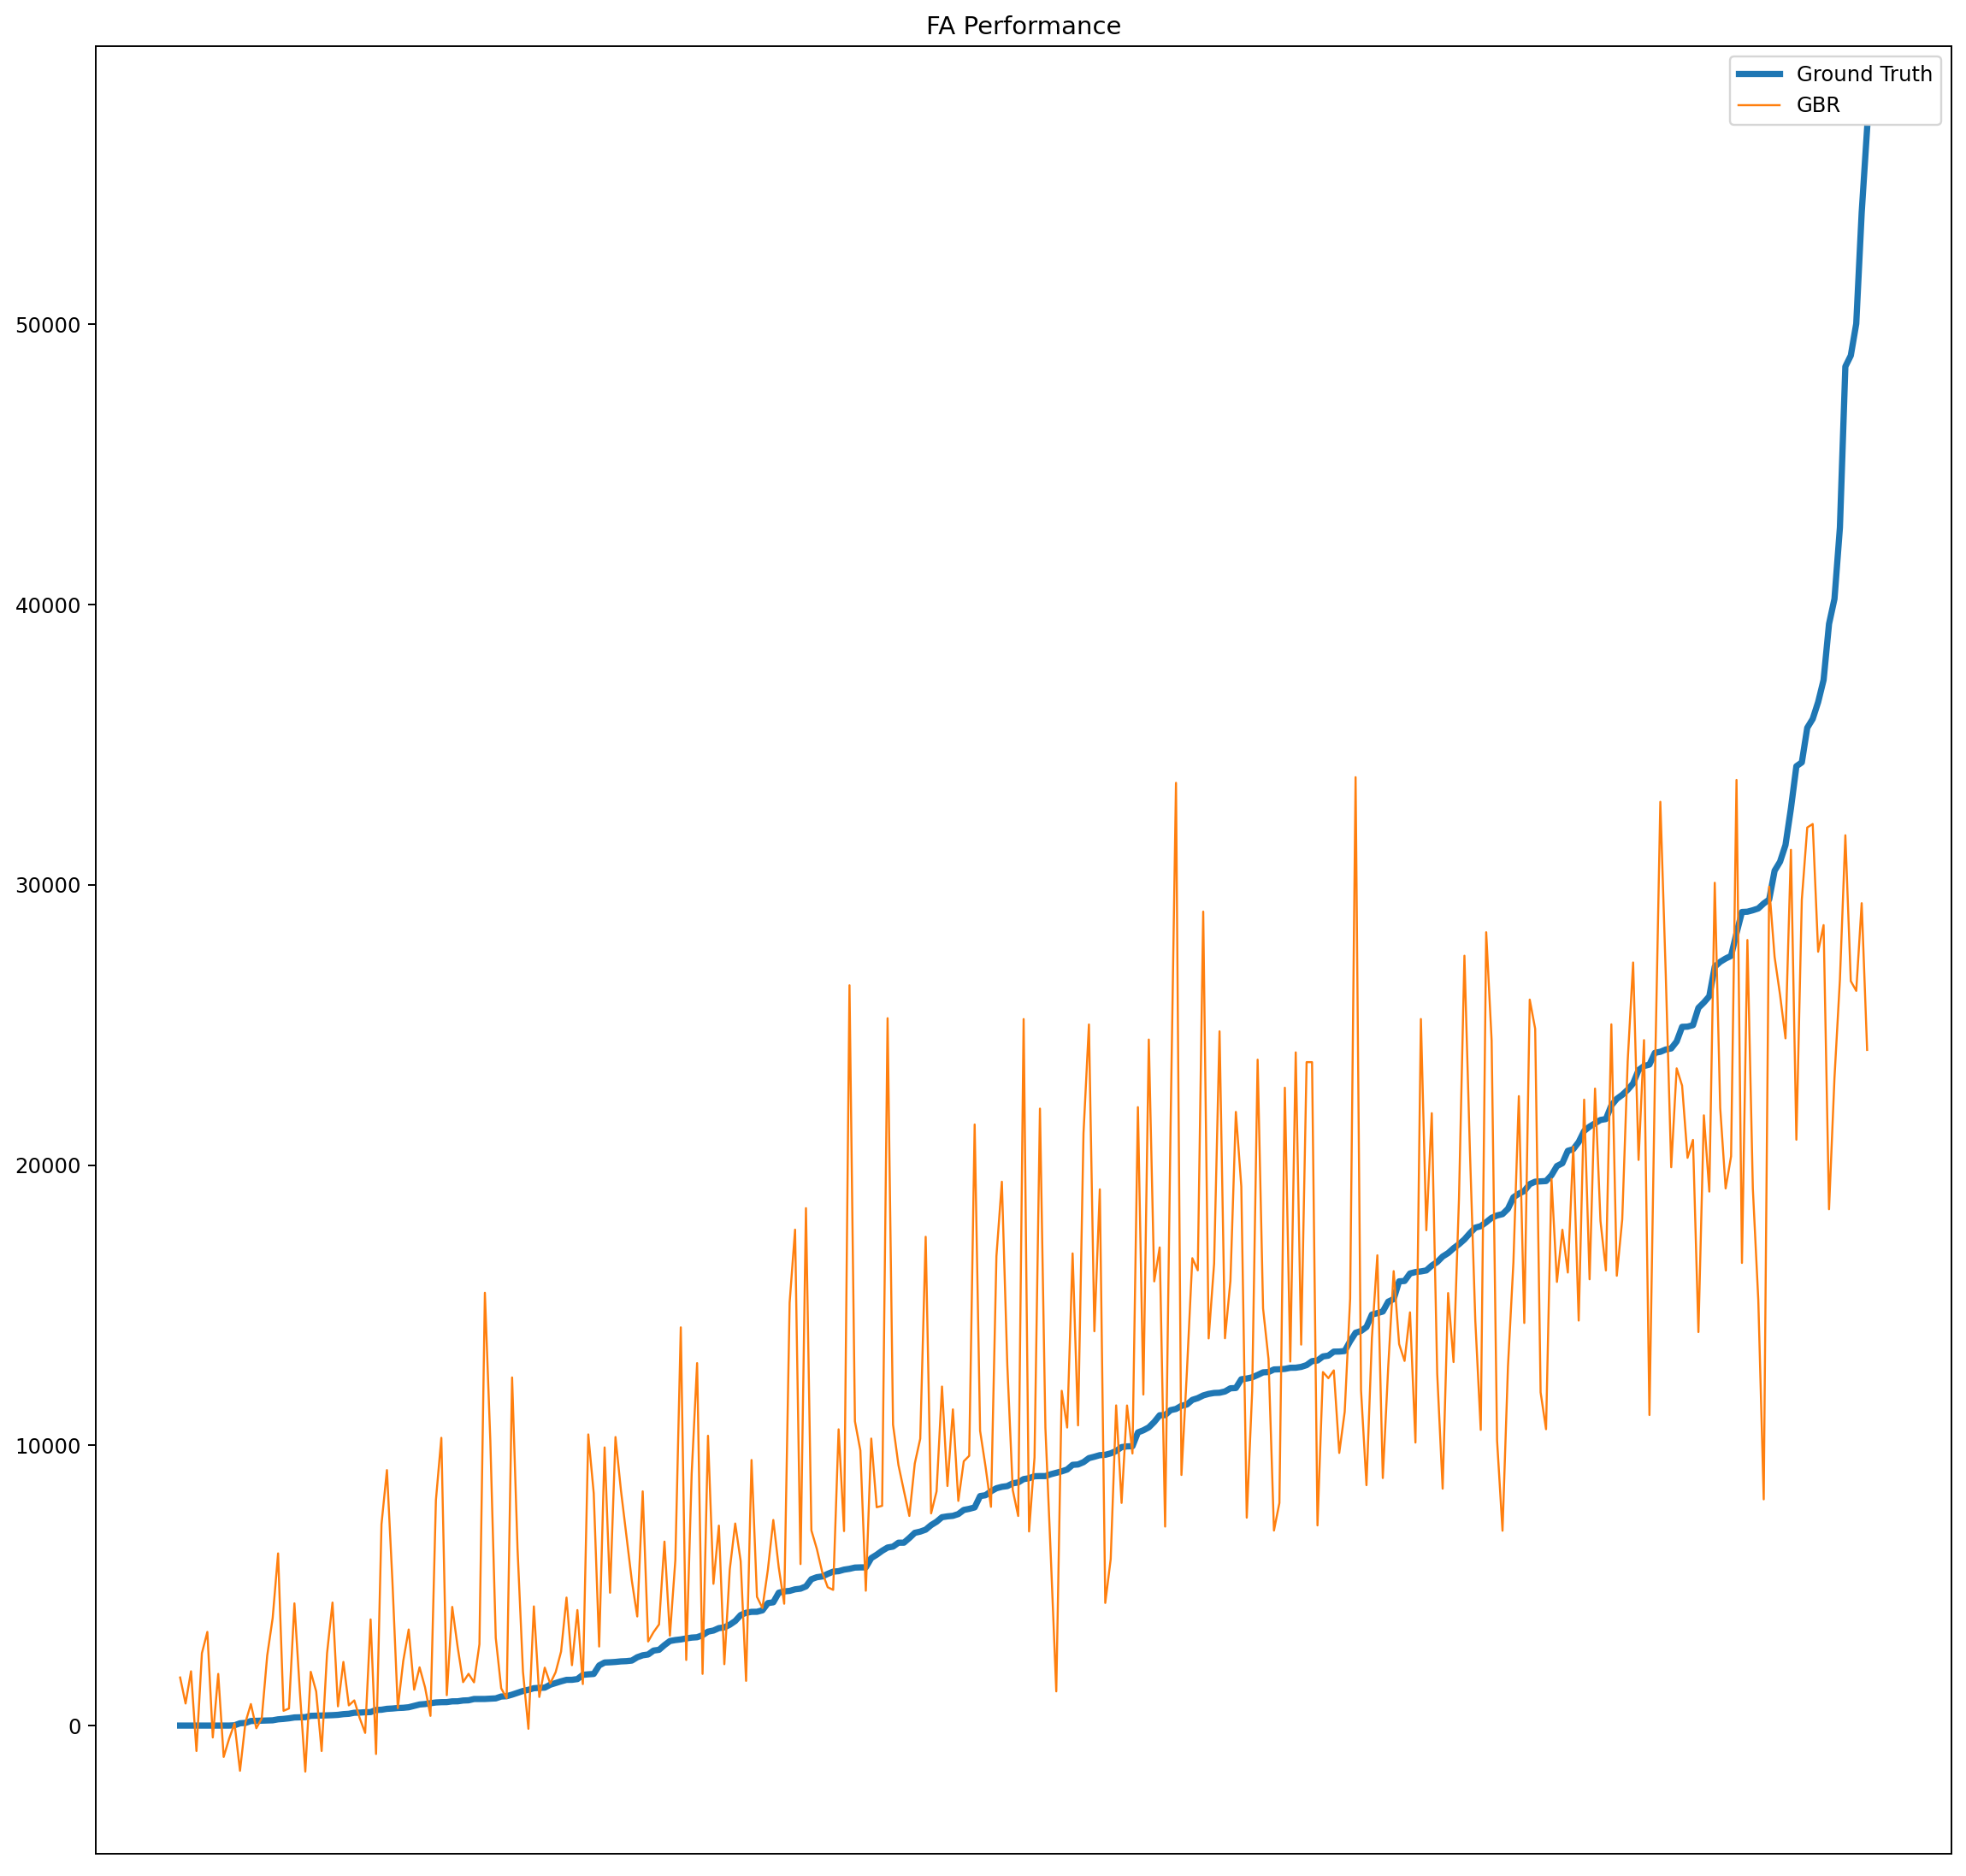

In [ ]:
plt.figure(facecolor=(1,1,1), figsize=(16, 16), dpi=175)
plt.title('FA Performance')
plt.plot(y_preds['Not_Vaccinated_Count'], label = 'Ground Truth', linewidth = 3)

#plt.plot(X_test_df.index, y_hat_dtr, label = 'DTR', linewidth = 1)
#plt.plot(X_test.index, y_hat_lin_reg, label = 'Lin Reg', linewidth = 1)
#plt.plot(X_test.index, y_hat_lasso, label = 'Lasso', linewidth = 1)
#plt.plot(X_test.index, y_hat_ridge, label = 'Ridge', linewidth = 1)  
#plt.plot(X_test.index, y_hat_enr, label = 'ENR', linewidth = 1)
#plt.plot(X_test.index, y_hat_knr, label = 'KNR', linewidth = 1)
#plt.plot(X_test_df.index, y_hat_rfr, label = 'RFR', linewidth = 1)
plt.plot(y_preds['y_hat_gbr'], label = 'GBR', linewidth = 1)

plt.gca().axes.get_xaxis().set_visible(False)
plt.legend()
plt.show()

In [ ]:
y_preds_z = y_test_z_df
y_preds_z['Not_Vaccinated_Count'] = standard_scaler_y.inverse_transform(y_test_z_df.values)
y_preds_z.head()

,Not_Vaccinated_Count
91024,3558.766797
90601,14785.820875
95655,2593.733077
94508,2921.756144
90038,14781.978333


In [ ]:
#y_preds['y_hat_gbr'] = y_hat_gbr
y_preds_z['y_hat_gbr_z'] = y_hat_gbr_z
y_preds_z.head()

,Not_Vaccinated_Count,y_hat_gbr_z
91024,3558.766797,5270.354811
90601,14785.820875,10043.473509
95655,2593.733077,4173.276590
94508,2921.756144,7797.341868
90038,14781.978333,12605.782103


In [ ]:
y_preds_z.sort_values(by= ['Not_Vaccinated_Count'], inplace=True)

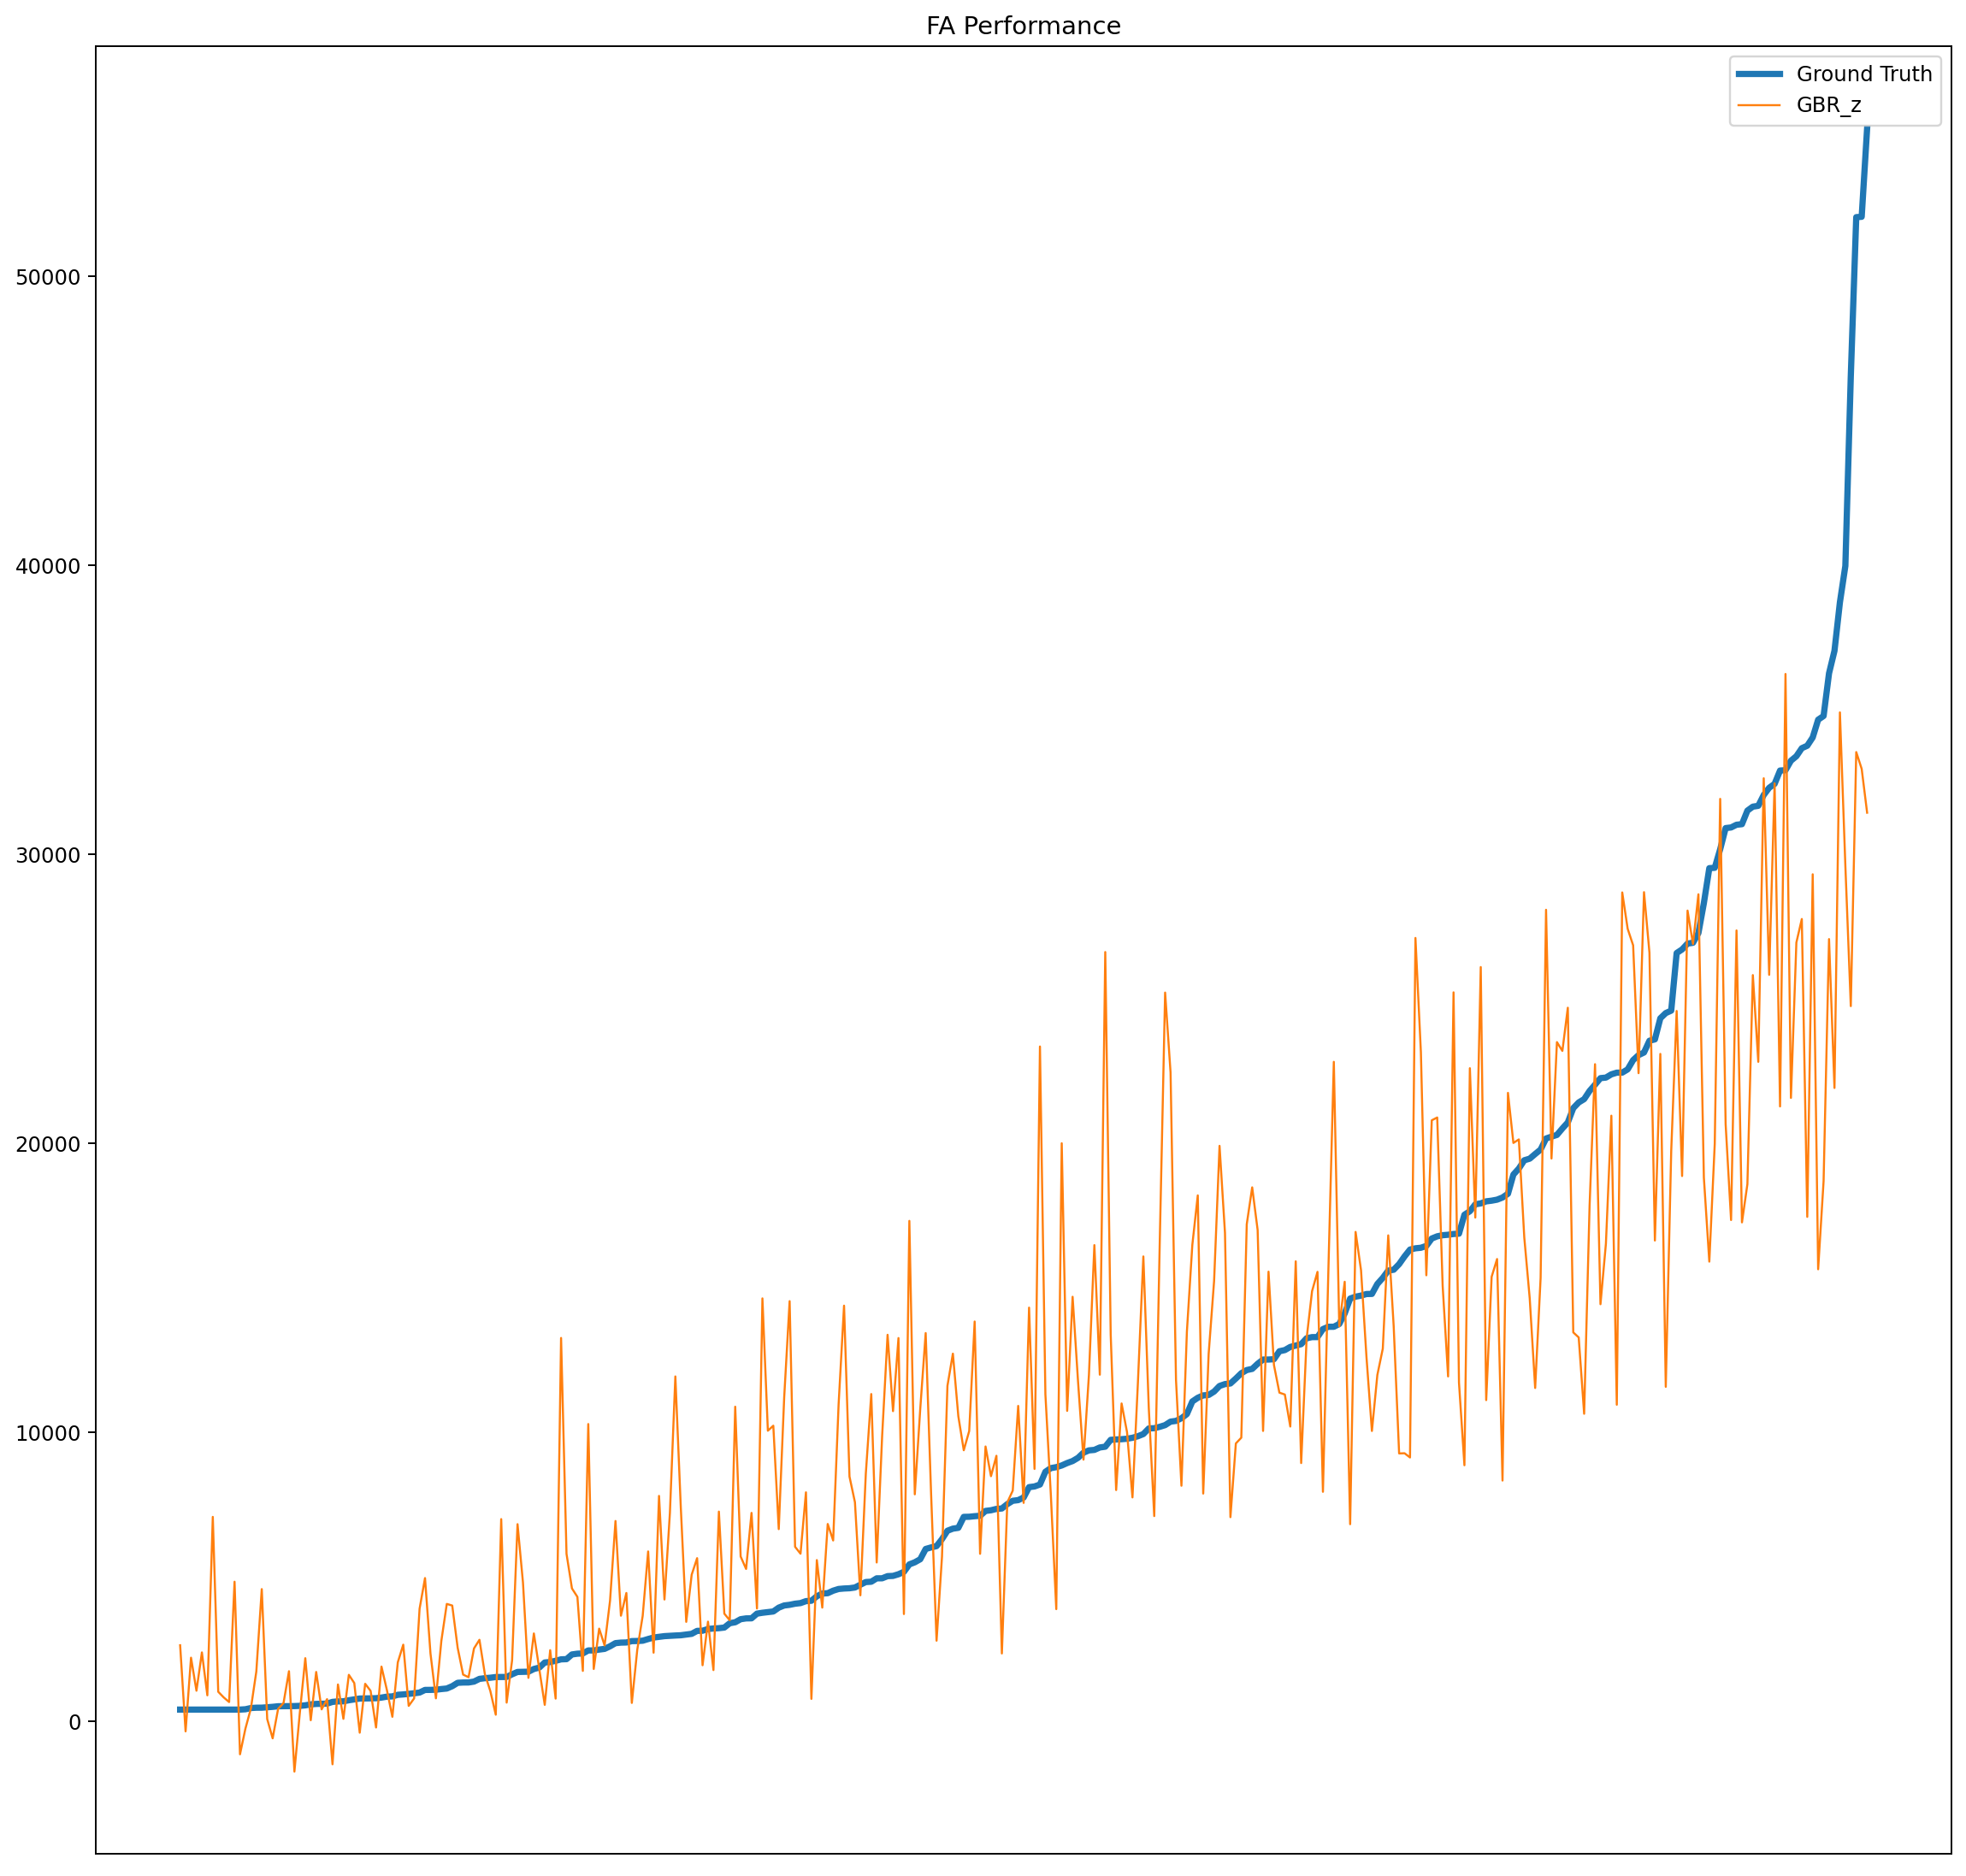

In [ ]:
plt.figure(facecolor=(1,1,1), figsize=(16, 16), dpi=175)
plt.title('FA Performance')
plt.plot(y_preds_z['Not_Vaccinated_Count'], label = 'Ground Truth', linewidth = 3)

#plt.plot(X_test_df.index, y_hat_dtr_z, label = 'DTR_z', linewidth = 2)
#plt.plot(X_test.index, y_hat_lin_reg_z, label = 'Lin Reg_z', linewidth = 1)
#plt.plot(X_test.index, y_hat_lasso_z, label = 'Lasso_z', linewidth = 1)
#plt.plot(X_test.index, y_hat_ridge_z, label = 'Ridge_z', linewidth = 1)  
#plt.plot(X_test.index, y_hat_enr_z, label = 'ENR_z', linewidth = 1)
#plt.plot(X_test.index, y_hat_knr_z, label = 'KNR_z', linewidth = 1)
#plt.plot(X_test_df.index, y_hat_rfr_z, label = 'RFR_z', linewidth = 2)
plt.plot(y_preds_z['y_hat_gbr_z'], label = 'GBR_z', linewidth = 1)



plt.gca().axes.get_xaxis().set_visible(False)
plt.legend()
plt.show()

In [ ]:
y_preds_s = y_test_s_df
y_preds_s['Not_Vaccinated_Count'] = standard_scaler_y.inverse_transform(y_test_s_df.values)
y_preds_s.head()

,Not_Vaccinated_Count
95358,21012.543221
95368,7873.616174
96056,1554.103062
95436,2920.849882
96148,408.574650


In [ ]:
#y_preds['y_hat_gbr'] = y_hat_gbr
y_preds_s['y_hat_gbr_s'] = y_hat_gbr_s
y_preds_s.head()

,Not_Vaccinated_Count,y_hat_gbr_s
95358,21012.543221,14120.512756
95368,7873.616174,19064.512120
96056,1554.103062,6335.914068
95436,2920.849882,9505.551088
96148,408.574650,10512.088022


In [ ]:
y_preds_s.sort_values(by= ['Not_Vaccinated_Count'], inplace=True)

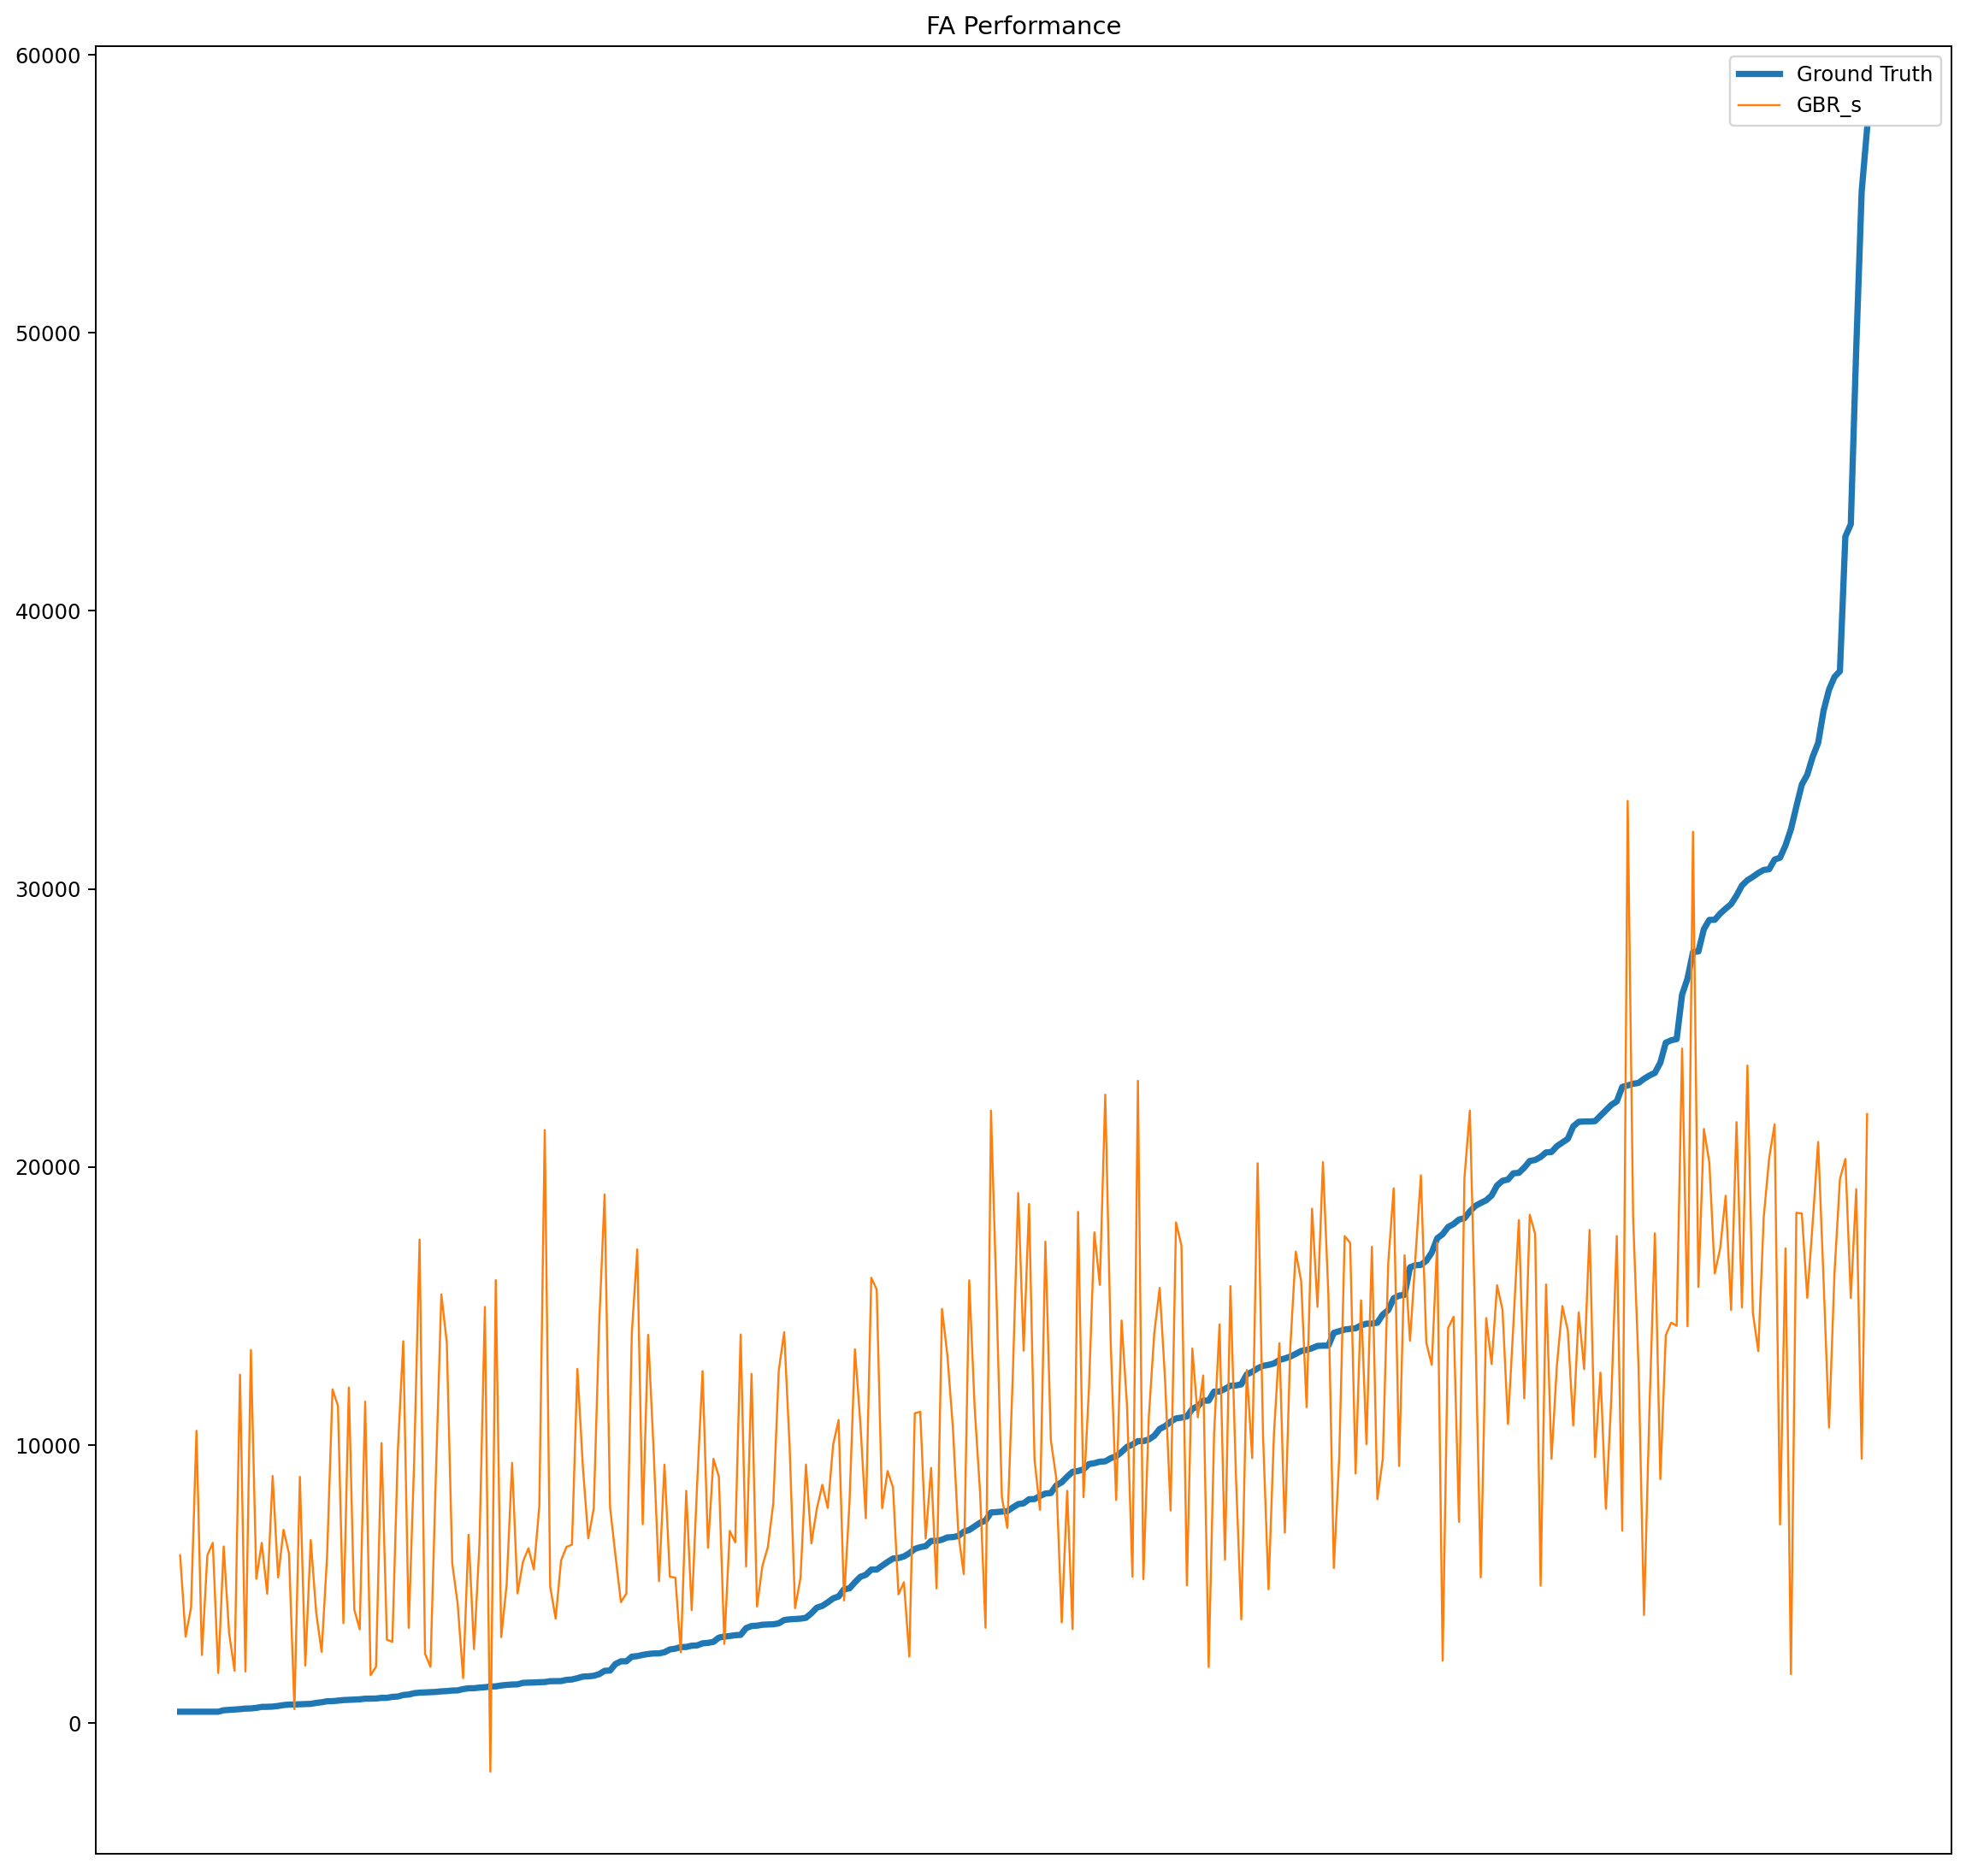

In [ ]:
plt.figure(facecolor=(1,1,1), figsize=(16, 16), dpi=175)
plt.title('FA Performance')
plt.plot(y_preds_s['Not_Vaccinated_Count'], label = 'Ground Truth', linewidth = 3)

#plt.plot(X_test_df.index, y_hat_dtr_z, label = 'DTR_z', linewidth = 2)
#plt.plot(X_test.index, y_hat_lin_reg_z, label = 'Lin Reg_z', linewidth = 1)
#plt.plot(X_test.index, y_hat_lasso_z, label = 'Lasso_z', linewidth = 1)
#plt.plot(X_test.index, y_hat_ridge_z, label = 'Ridge_z', linewidth = 1)  
#plt.plot(X_test.index, y_hat_enr_z, label = 'ENR_z', linewidth = 1)
#plt.plot(X_test.index, y_hat_knr_z, label = 'KNR_z', linewidth = 1)
#plt.plot(X_test_df.index, y_hat_rfr_z, label = 'RFR_z', linewidth = 2)
plt.plot(y_preds_s['y_hat_gbr_s'], label = 'GBR_s', linewidth = 1)



plt.gca().axes.get_xaxis().set_visible(False)
plt.legend()
plt.show()

In [ ]:
#THIS METRIC DOES NOT WORK
from sklearn.metrics import explained_variance_score
print('DTR:', explained_variance_score(y_test, y_hat_dtr), 'RFR:', explained_variance_score(y_test, y_hat_rfr),'GBR:',explained_variance_score(y_test, y_hat_gbr))

DTR: 0.16265452893531618 RFR: 0.5966654269906739 GBR: 0.5948840409046936


In [ ]:
from sklearn.metrics import explained_variance_score
print('DTR_z:', explained_variance_score(y_test_z , y_hat_dtr_z), 'RFR_z:', explained_variance_score(y_test_z , y_hat_rfr_z),'GBR_z:',explained_variance_score(y_test_z, y_hat_gbr_z))

DTR_z: 0.28146526132745997 RFR_z: 0.6891072687420075 GBR_z: 0.7135056917539835


In [ ]:
from sklearn.metrics import explained_variance_score
print('DTR_s:', explained_variance_score(y_test_s , y_hat_dtr_s), 'RFR_s:', explained_variance_score(y_test_s , y_hat_rfr_s),'GBR_s:',explained_variance_score(y_test_s, y_hat_gbr_s))

DTR_s: -0.6384545344124111 RFR_s: 0.3012052119473143 GBR_s: 0.3023918067989859


In [ ]:
y_test_z_df.values

array([[ 4.03508293e+02,  2.63004797e+03],
       [ 4.03508293e+02, -3.49548409e+02],
       [ 4.03508293e+02,  2.19964335e+03],
       [ 4.03508293e+02,  1.05625744e+03],
       [ 4.03508293e+02,  2.38183479e+03],
       [ 4.03508293e+02,  8.96737556e+02],
       [ 4.03508293e+02,  7.07139700e+03],
       [ 4.03508293e+02,  1.02028290e+03],
       [ 4.03508293e+02,  8.25790506e+02],
       [ 4.03508293e+02,  6.64399660e+02],
       [ 4.03508293e+02,  4.82815742e+03],
       [ 4.03508293e+02, -1.14334677e+03],
       [ 4.14782288e+02, -2.52314728e+02],
       [ 4.57393026e+02,  4.41654838e+02],
       [ 4.68397066e+02,  1.72055247e+03],
       [ 4.69794201e+02,  4.57283590e+03],
       [ 4.83805610e+02,  7.59252168e+01],
       [ 4.98636994e+02, -5.90645704e+02],
       [ 5.18811918e+02,  4.26266848e+02],
       [ 5.21048250e+02,  6.31417287e+02],
       [ 5.24376544e+02,  1.73128645e+03],
       [ 5.24731135e+02, -1.74202393e+03],
       [ 5.32942698e+02,  3.04404854e+02],
       [ 5.